### Installations of requirements

In [1]:
!sed -i s/https/http/g /opt/conda/envs/python2/lib/python2.7/site-packages/idr/externalDBs.py

### Import libraries and global variables

In [2]:
import pandas

from ipywidgets import widgets, interact, fixed
from functools import wraps
from IPython.display import display, HTML

from idr.connections import connection, create_http_session
from idr.externalDBs import genes_of_interest_go
from idr.widgets import textbox_widget
from idr.widgets import dropdown_widget
from idr.attributes import get_phenotypes_for_genelist, get_similar_genes

from idr.visualizations import plot_idr_attributes, plot_string_interactions
from idr.externalDBs import genes_of_interest_from_string

import seaborn as sns
import matplotlib.pyplot as plt

## Querying

### Variables:

In [3]:
organisms_list = ['Homo sapiens', 'Saccharomyces cerevisiae']
org_sel = dropdown_widget(organisms_list, 'Select Organism:', True)
tax_id = textbox_widget('9606', 'Enter Taxonomy Id for Organism', "Taxonomy Id:", True)
go_term = textbox_widget('GO:0005885', 'Enter GO Id', 'Gene Ontology Id:', True)
manual_gene_list = textbox_widget('','Comma seperated gene symbols', 'Manual Gene List:', True)

Dropdown(description=u'Select Organism:', options=('Homo sapiens', 'Saccharomyces cerevisiae'), value='Homo sapiens')

Text(value=u'9606', description=u'Taxonomy Id:', placeholder=u'Enter Taxonomy Id for Organism')

Text(value=u'GO:0005885', description=u'Gene Ontology Id:', placeholder=u'Enter GO Id')

Text(value=u'', description=u'Manual Gene List:', placeholder=u'Comma seperated gene symbols')

### Import query list

In [4]:
go_gene_list = []
if go_term.value.split(",") != ['']:
    go_gene_list = genes_of_interest_go(go_term.value, tax_id.value)
else:
    print 'Please enter a valid Gene Ontology Id'
manual_list = manual_gene_list.value.split(",")
if manual_list != ['']:
    go_gene_list = list(set(go_gene_list + manual_list))
print "Query list of genes:",go_gene_list

Query list of genes: ['ARPC4-TTLL3', 'ACTR2', 'ACTR3', 'ARPC3', 'ARPC1B', 'ARPC1A', 'ARPC5L', 'ACTR3C', 'ACTR3B', 'ARPC5', 'ARPC2', 'HEL-68', 'FKSG72', 'FKSG73', 'FKSG74', 'HEL-S-307', 'ARPC4']


### Query IDR for Phenotypes

In [5]:
session = create_http_session()
organism = org_sel.value

[query_genes_dataframe, screen_to_phenotype_dictionary] = get_phenotypes_for_genelist(session, go_gene_list, organism)
display(HTML(query_genes_dataframe.to_html( escape=False)))

,Entrez,Ensembl,Key,Value,PhenotypeName,PhenotypeAccession,ScreenIds
ARPC2,[10109],[ENSG00000163466],GeneName,ARPC2,"[decreased cell numbers, geometric cell phenot...","[CMPO_0000274, CMPO_0000299, CMPO_0000276, CMP...","[206, 206, 206, 206, 206, 206, 206, 206, 206, ..."
ARPC1A,[10552],[ENSG00000241685],GeneName,ARPC1A,[strong decrease in rate of protein secretion],[CMPO_0000319],[251]
ARPC5L,[81873],[ENSG00000136950],GeneName,ARPC5L,"[increased actin localised to the nucleus, elo...","[CMPO_0000261, CMPO_0000287, CMPO_0000288, CMP...","[206, 206, 206, 206, 206, 206, 206, 206, 206, ..."
ACTR3C,[653857],[ENSG00000106526],EnsemblID,ENSG00000106526,"[cell death phenotype, mitosis delayed phenoty...","[CMPO_0000305, CMPO_0000348, CMPO_0000307, CMP...","[1101, 1101, 1101, 1101, 1101, 1101, 1101]"
ACTR3B,[57180],[ENSG00000133627],GeneName,ACTR3B,[binuclear cell phenotype],[CMPO_0000213],[1101]
HEL-68,[10552],[ENSG00000241685],EnsemblID,ENSG00000241685,[strong decrease in rate of protein secretion],[CMPO_0000319],[251]
ARPC4,[10093],[ENSG00000241553],GeneName,ARPC4,[mild decrease in rate of protein secretion],[CMPO_0000318],[251]
ACTR3,[10096],[ENSG00000115091],GeneName,ACTR3,"[strong decrease in rate of protein secretion,...","[CMPO_0000319, CMPO_0000319]","[251, 803]"


### Get Other Genes from the phenotypes

In [6]:
conn = connection()
try:
    query_genes_list = list(query_genes_dataframe['Value'])
    [similar_genes, overlap_genes] = get_similar_genes(conn, query_genes_list, screen_to_phenotype_dictionary)
    overlap_genes_dataframe = pandas.DataFrame.from_dict(overlap_genes, orient='index')
    display(HTML("<strong>Query Genes:</strong>"))
    display(HTML(overlap_genes_dataframe.to_html( escape=False)))
    
    similar_genes_dataframe = pandas.DataFrame.from_dict(similar_genes, orient='index')
    display(HTML("<strong>Similar Genes:</strong>"))
    display(HTML(similar_genes_dataframe.to_html( escape=False)))
finally:
    conn.close()    

Connected to IDR...


,strong decrease in rate of protein secretion,mild decrease in rate of protein secretion,cell death phenotype,mitosis delayed phenotype,metaphase delayed phenotype,mitosis arrested,mitotic metaphase plate congression phenotype,binuclear cell phenotype,abnormal cell cycle phenotype,metaphase arrested phenotype,decreased cell numbers,elongated cell phenotype,increased actin localised to the nucleus,round cell phenotype,fan-shaped lamellipodia phenotype,increased amount of zig-zag stress fibers,microtubules nuclear bracket phenotype,more multinucleate cells,increased variability of cell shape in population,disorganised cortical actin cytoskeleton phenotype,microtubules nuclear ring phenotype,increased lamellipodia width phenotype,increased amount of stress fibers phenotype,increased amount of transverse stress fibers,increased cell size phenotype,geometric cell phenotype
1101,NaN,NaN,[ACTR3C],[ACTR3C],[ACTR3C],[ACTR3C],[ACTR3C],"[ARPC2, ACTR3B]",[ACTR3C],[ACTR3C],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1302,NaN,NaN,NaN,NaN,[ARPC2],NaN,NaN,NaN,NaN,[ARPC2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[ARPC2, ARPC5L]",[ARPC5L],[ARPC5L],[ARPC5L],[ARPC5L],[ARPC2],[ARPC5L],[ARPC2],[ARPC5L],"[ARPC2, ARPC5L]",[ARPC5L],"[ARPC2, ARPC5L]","[ARPC2, ARPC5L]","[ARPC2, ARPC5L]","[ARPC2, ARPC5L]","[ARPC2, ARPC5L]"
251,"[ARPC1A, ACTR3]",[ARPC4],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
803,[ACTR3],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,strong decrease in rate of protein secretion,mild decrease in rate of protein secretion,cell death phenotype,mitosis delayed phenotype,metaphase delayed phenotype,mitosis arrested,mitotic metaphase plate congression phenotype,binuclear cell phenotype,abnormal cell cycle phenotype,metaphase arrested phenotype,decreased cell numbers,elongated cell phenotype,increased actin localised to the nucleus,round cell phenotype,fan-shaped lamellipodia phenotype,increased amount of zig-zag stress fibers,microtubules nuclear bracket phenotype,more multinucleate cells,increased variability of cell shape in population,disorganised cortical actin cytoskeleton phenotype,microtubules nuclear ring phenotype,increased lamellipodia width phenotype,increased amount of stress fibers phenotype,increased amount of transverse stress fibers,increased cell size phenotype,geometric cell phenotype
1101,NaN,NaN,"[ENSG00000124209, ENSG00000134955, ZDHHC17, OR...","[ENSG00000124209, , ASCC3L1, ENSG00000164542, ...","[ENSG00000124209, , ASCC3L1, MFAP1, ENSG000001...","[ENSG00000124209, , ASCC3L1, ENSG00000164542, ...","[ENSG00000124209, , ASCC3L1, ENSG00000148136, ...","[, OPRS1, CPM, GALC, STK16, ENSG00000187221, E...","[ENSG00000124209, , ASCC3L1, ENSG00000148136, ...","[ENSG00000124209, , ASCC3L1, MFAP1, ENSG000001...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1302,NaN,NaN,NaN,NaN,"[NUTF2, LGR4, ENSG00000131323, ENSG00000076344...",NaN,NaN,NaN,NaN,"[NUTF2, LGR4, ENSG00000131323, ENSG00000076344...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[BAF53A, ACTG1, LASP1, LHX3, FMNL1, RAMP, ARHG...","[C6ORF168, BAF53A, PTK2, CYFIP1, MYH15, RASD1,...","[MYH15, RAD51L3, RACGAP1P, RHOT2, SPTBN5, SPTB...","[MAP4K3, PLXNB1, DMD, MYH15, MYH4, P8, NUPR1, ...","[CAPZB, BAF53A, PTK2, CYFIP1, C6ORF168, LOC201...","[TPM4, CYFIP1, ACTG1, RASD1, DTL, LOC201176, M...","[EPB41L1, MINK1, CAPZA1, MINK, DBNL, MYH15, WD...","[CAPZB, BAF53A, PTK2, DMD, ACTG1, RASD1, DTL, ...","[C6ORF168, MAP4K3, PTK2, DMD, MYH15, RASD1, TM...","[BAF53A, LHX3, FMNL1, RAMP, ARHGAP27, ARHGAP26...","[CAPZB, MAP4K3, DMD, ACTG1, TMSB4X, MYO1F, SPT...","[BAF53A, ACTG1, LHX3, FMNL1, RAMP, ARHGAP27, A...","[C6ORF168, MAP4K3, CYFIP1, ACTG1, LOC201176, M...","[MAP4K3, PTK2, CYFIP1, ACTG1, RASD1, MYO1F, RA...","[CAPZB, BAF53A, CYFIP1, ACTG1, RASD1, DTL, TMS...","[C6ORF168, MAP4K3, TPM4, CYFIP1, ACTG1, RASD1,..."
251,"[ENSG00000167693, HIF3A, ENSG00000111358, RNF1...","[ENSG00000102054, ENSG00000124209, ENSG0000011...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
803,"[ENSG00000100532, UBE2Q2, ZCCHC17, ENSG0000014...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualisation

### Plot Query Genes

In [7]:
%matplotlib inline
filter_by_category=widgets.Dropdown(description='Filter_by_category', options=['Phenotypes','Screens'])
threshold_for_category = widgets.IntSlider(description='Threshold_for_category', min=1,max=10,step=1,value=1)
threshold_for_plot = widgets.IntSlider(description='Threshold_for_plot', min=1,max=10,step=1,value=1)
@interact(primary_dictionary=fixed(overlap_genes), secondary_dictionary=fixed(overlap_genes), plot_title=fixed('Query Genes'), filter_by_category = filter_by_category, threshold_for_category = threshold_for_category, threshold_for_plot = threshold_for_plot)
@wraps(plot_idr_attributes)
def myfun(**kwargs):
    global screenids_removed, phenotypes_removed, genes_of_interest
    [screenids_removed, phenotypes_removed, genes_of_interest] = plot_idr_attributes(**kwargs)

interactive(children=(IntSlider(value=1, description=u'Threshold_for_plot', max=10, min=1), IntSlider(value=1, description=u'Threshold_for_category', max=10, min=1), Dropdown(description=u'Filter_by_category', options=('Phenotypes', 'Screens'), value='Phenotypes'), Output()), _dom_classes=('widget-interact',))

### Plot Similar Genes

In [8]:
for ids in screenids_removed:
    if ids in similar_genes:
        del similar_genes[ids]

@interact(primary_dictionary=fixed(similar_genes), secondary_dictionary=fixed(overlap_genes), plot_title=fixed('Similar genes'), filter_by_category = fixed(filter_by_category.value), threshold_for_category = fixed(threshold_for_category.value),threshold_for_plot = widgets.IntSlider(min=1,max=10,step=1,value=4))
@wraps(plot_idr_attributes)
def myfun(**kwargs):
    global screenids_removed, phenotypes_removed, genes_of_interest
    [screenids_removed, phenotypes_removed, genes_of_interest] = plot_idr_attributes(**kwargs)
    
similar_genes_list = genes_of_interest

interactive(children=(IntSlider(value=4, description=u'threshold_for_plot', max=10, min=1), Output()), _dom_classes=('widget-interact',))

### Get String Interactions

### Plot string interactions between similar genes and query genes/similar genes

Primary Interactors:


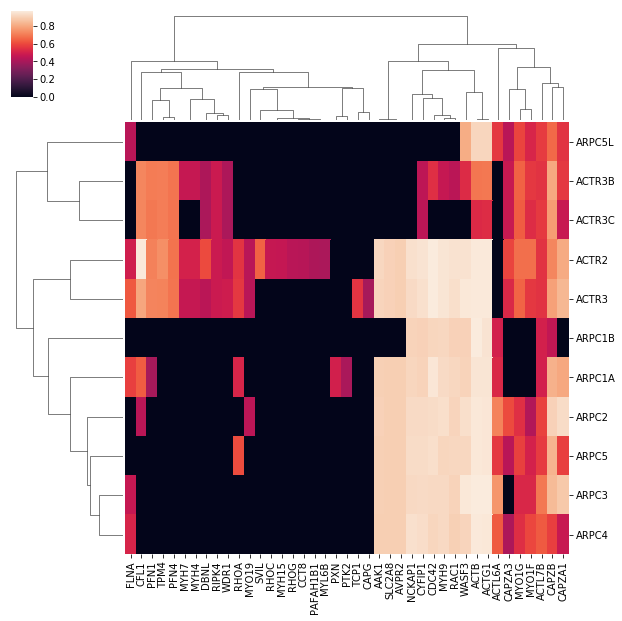

Secondary Interactors:


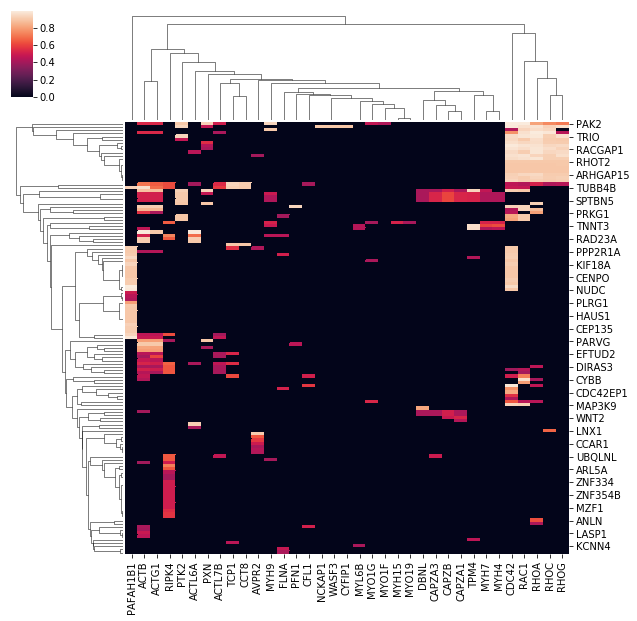

In [9]:
similar_genes_list = list(set(genes_of_interest) - set(go_gene_list))
genes_of_interest1 = list(set(go_gene_list + similar_genes_list))
interactions_dataframe = genes_of_interest_from_string(genes_of_interest1, 1, tax_id.value)

print 'Primary Interactors:'
df = plot_string_interactions(go_gene_list, similar_genes_list, interactions_dataframe)

primary_genes = list(df.columns.values)
secondary_genes = set(similar_genes_list) - set(primary_genes)
print 'Secondary Interactors:'
df = plot_string_interactions(secondary_genes, primary_genes, interactions_dataframe)

All Interactors:


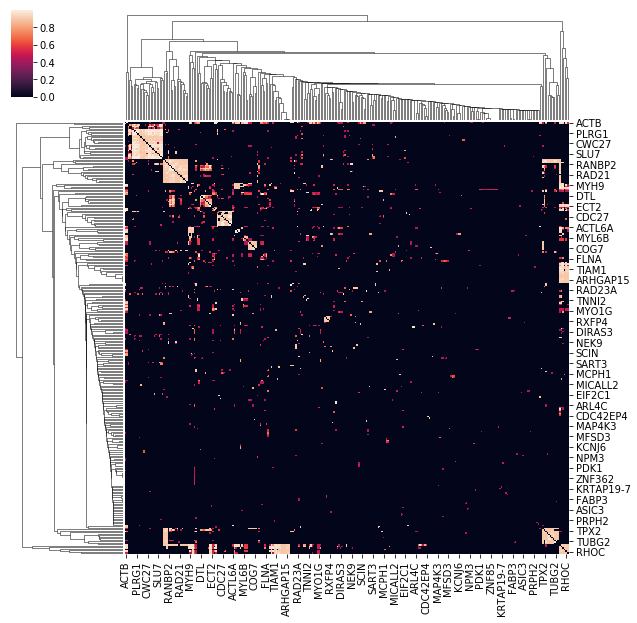

In [10]:
print 'All Interactors:'
secondary_genes = set(similar_genes_list)
df = plot_string_interactions(secondary_genes, secondary_genes, interactions_dataframe)